In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline

In [36]:
path = "."
normalize = transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])

transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform)
              for x in ["train", "val"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = 4,
                                                shuffle = True)
                     for x in ["train", "val"]}

In [3]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [4]:


classes = data_image["train"].classes
classes_index = data_image["train"].class_to_idx
print(classes)
print(classes_index)



['cat', 'dog']
{'cat': 0, 'dog': 1}


In [5]:
print(u"训练集个数:", len(data_image["train"]))
print(u"验证集个数:", len(data_image["val"]))

训练集个数: 22500
验证集个数: 2500


['cat', 'dog', 'dog', 'cat']


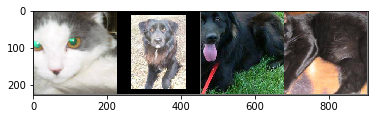

In [6]:
X_train, y_train = next(iter(data_loader_image["train"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print([classes[i] for i in y_train])
plt.imshow(img)

In [7]:


model = models.vgg16(pretrained=True)



In [ ]:
print(model)

In [22]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

for index, parma in enumerate(model.classifier.parameters()):
    if index == 6:
        parma.requires_grad = True
    
if use_gpu:
    model = model.cuda()


cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

In [ ]:


print(model)



In [23]:
n_epochs = 1
for epoch in range(n_epochs):
    since = time.time()
    print("Epoch{}/{}".format(epoch, n_epochs))
    print("-"*10)
    for param in ["train", "val"]:
        if param == "train":
            model.train = True
        else:
            model.train = False

        running_loss = 0.0
        running_correct = 0 
        batch = 0
        for data in data_loader_image[param]:
            batch += 1
            X, y = data
            if use_gpu:
                X, y  = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
        
            optimizer.zero_grad()
            y_pred = model(X)
            _, pred = torch.max(y_pred.data, 1)
        
            loss = cost(y_pred, y)
            if param =="train":
                loss.backward()
                optimizer.step()
            running_loss += loss.data[0]
            running_correct += torch.sum(pred == y.data)
            if batch%500 == 0 and param =="train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                      batch, running_loss/(4*batch), 100*running_correct/(4*batch)))
            
        epoch_loss = running_loss/len(data_image[param])
        epoch_correct = 100*running_correct/len(data_image[param])

        print("{}  Loss:{:.4f},  Correct{:.4f}".format(param, epoch_loss, epoch_correct))
    now_time = time.time() - since   
    print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

Epoch0/1
----------
Batch 500, Train Loss:0.9734, Train ACC:88.2000
Batch 1000, Train Loss:1.0248, Train ACC:90.2250
Batch 1500, Train Loss:0.9188, Train ACC:91.2667
Batch 2000, Train Loss:0.7867, Train ACC:91.8750
Batch 2500, Train Loss:0.7406, Train ACC:92.3600
Batch 3000, Train Loss:0.7256, Train ACC:92.5750
Batch 3500, Train Loss:0.7078, Train ACC:92.8143
Batch 4000, Train Loss:0.6592, Train ACC:93.1500
Batch 4500, Train Loss:0.6361, Train ACC:93.3000
Batch 5000, Train Loss:0.6106, Train ACC:93.4000
Batch 5500, Train Loss:0.5860, Train ACC:93.5318
train  Loss:0.5795,  Correct93.5511
val  Loss:0.2586,  Correct96.5600
Training time is:5m 29s


In [24]:
torch.save(model.state_dict(), "model_vgg16_finetune.pkl")

In [38]:
import torch.utils.data as data
from PIL import Image

class TestImageFolder(data.Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in os.listdir(root):
            if filename.endswith('jpg'):
                images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [34]:
test_loader = data.DataLoader(
    TestImageFolder('./test/',
                    transforms.Compose([
                        transforms.Scale(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        normalize,
                    ])),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=False)

In [ ]:
data_loader_test_img.dataset.imgs

In [79]:
import torch.nn as nn
for i, (image, filepath) in enumerate(test_loader):
    print(i)
    images = Variable(image.cuda())
    y_pred = model(images)
    _, pred = torch.max(y_pred.data, 1)
#     print(y_pred.data)
    smax = nn.Softmax()
    smax_out = smax(y_pred)[0]
    cat_prob = smax_out.data[0]
    dog_prob = smax_out.data[1]
    prob = dog_prob
    if cat_prob > dog_prob:
        prob = 1 - cat_prob
    prob = np.around(prob, decimals=4)
#     prob = np.clip(prob, .0001, .999)
    print(prob)
    img = img*std+mean
    print("Pred Label:",[classes[i] for i in pred])
    if i > 100:
        break

0
0.0
Pred Label: ['cat']
1
0.0
Pred Label: ['cat']
2
0.0
Pred Label: ['cat']
3
0.0
Pred Label: ['cat']
4
0.0
Pred Label: ['cat']
5
0.0
Pred Label: ['cat']
6
1.0
Pred Label: ['dog']
7
0.0
Pred Label: ['cat']
8
0.0
Pred Label: ['cat']
9
0.0
Pred Label: ['cat']
10
1.0
Pred Label: ['dog']
11
0.0
Pred Label: ['cat']
12
0.0
Pred Label: ['cat']
13
0.0
Pred Label: ['cat']
14
1.0
Pred Label: ['dog']
15
1.0
Pred Label: ['dog']
16
1.0
Pred Label: ['dog']
17
1.0
Pred Label: ['dog']
18
1.0
Pred Label: ['dog']
19
1.0
Pred Label: ['dog']
20
0.0
Pred Label: ['cat']
21
0.0
Pred Label: ['cat']
22
0.0
Pred Label: ['cat']
23
1.0
Pred Label: ['dog']
24


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


1.0
Pred Label: ['dog']
25
1.0
Pred Label: ['dog']
26
0.0
Pred Label: ['cat']
27
1.0
Pred Label: ['dog']
28
1.0
Pred Label: ['dog']
29
0.0
Pred Label: ['cat']
30
0.0
Pred Label: ['cat']
31
0.0
Pred Label: ['cat']
32
1.0
Pred Label: ['dog']
33
0.0
Pred Label: ['cat']
34
1.0
Pred Label: ['dog']
35
0.0
Pred Label: ['cat']
36
1.0
Pred Label: ['dog']
37
1.0
Pred Label: ['dog']
38
1.0
Pred Label: ['dog']
39
0.0
Pred Label: ['cat']
40
0.0
Pred Label: ['cat']
41
1.0
Pred Label: ['dog']
42
1.0
Pred Label: ['dog']
43
0.0
Pred Label: ['cat']
44
1.0
Pred Label: ['dog']
45
0.0
Pred Label: ['cat']
46
0.0
Pred Label: ['cat']
47
1.0
Pred Label: ['dog']
48
1.0
Pred Label: ['dog']
49
1.0
Pred Label: ['dog']
50
1.0
Pred Label: ['dog']
51
0.0
Pred Label: ['cat']
52
1.0
Pred Label: ['dog']
53
1.0
Pred Label: ['dog']
54
1.0
Pred Label: ['dog']
55
0.0
Pred Label: ['cat']
56
0.0
Pred Label: ['cat']
57
0.0
Pred Label: ['cat']
58
0.0
Pred Label: ['cat']
59
0.0
Pred Label: ['cat']
60
1.0
Pred Label: ['dog']
61
0

In [26]:
image, label = next(iter(data_loader_test_img))
images = Variable(image.cuda())
y_pred = model(images)
_, pred = torch.max(y_pred.data, 1)
print(pred)


 1
 0
 0
 1
 1
 0
 0
 1
 1
 0
[torch.cuda.LongTensor of size 10 (GPU 0)]



In [30]:
type(label)

torch.LongTensor

Pred Label: ['dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat']


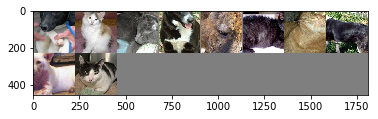

In [35]:
img = torchvision.utils.make_grid(image)
img = img.numpy().transpose(1,2,0)
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = img*std+mean
print("Pred Label:",[classes[i] for i in pred])
plt.imshow(img)

/usr/local/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [50]:
for i, (images, filepath) in enumerate(test_loader):
    print(filepath)
    break

('3353.jpg',)
